<a href="https://colab.research.google.com/github/Arifuzzamanjoy/BAMSE/blob/master/image_classification_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning for Image Classification with Transformers**

In this project, I'll try to show how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

And at the end of this project, we are hoping to get better accuracy than the popular models like GoogleNet & Alexnet.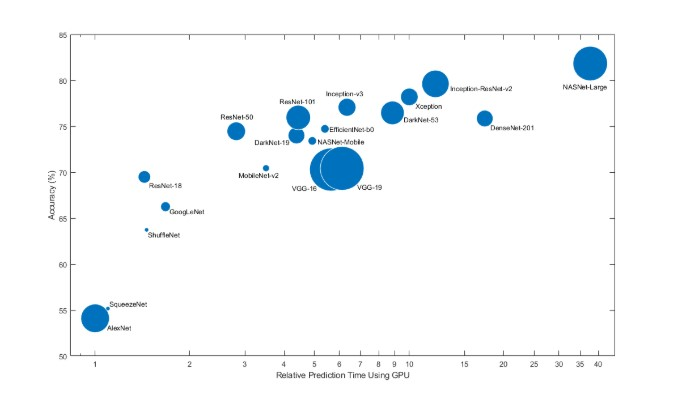

In [ ]:
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.9 MB/s eta 0:00:00


In [ ]:
#model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
model_checkpoint="google/vit-base-patch16-224"
batch_size = 32 # batch size for training and evaluation

Before we start, let's install the `datasets` and `transformers` libraries.

In [ ]:

!pip install -q datasets transformers

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00


## Fine-tuning a model on an image classification task

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install rarfile
!apt-get install unrar
import rarfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


### Loading the dataset

In [ ]:
from datasets import load_dataset
from google.colab import drive

# local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
dataset = load_dataset("imagefolder", data_files="/content/drive/MyDrive/oregon_wildlife.rar")



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [ ]:


from datasets import load_metric

metric = load_metric("accuracy")


The `dataset` object itself is a `DatasetDict`, which contains one key per split (in this case, only "train" for a training split).

In [ ]:
dataset
print(dataset['train'][0])
# Show the image
dataset["train"][0]["image"].show()


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x3456 at 0x7D1D5068A530>, 'label': 0}


To access an actual element, you need to select a split first, then give an index:

In [ ]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=260x390>,
 'label': 0}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['bald_eagle', 'black_bear', 'bobcat', 'canada_lynx', 'columbian_black-tailed_deer', 'cougar', 'coyote', 'deer', 'elk', 'gray_fox', 'gray_wolf', 'mountain_beaver', 'nutria', 'raccoon', 'raven', 'red_fox', 'ringtail', 'sea_lions', 'seals', 'virginia_opossum'], id=None)}

We can directly view the image as follows:

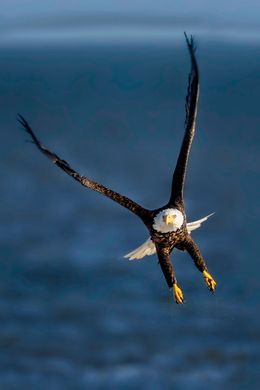

In [ ]:
example['image']

Let's try resizing the image.

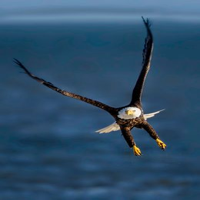

In [ ]:
example['image'].resize((200, 200))

Let's print the corresponding label:

In [ ]:
example['label']

0

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [ ]:
dataset["train"].features['label'].names[1]

'black_bear'

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [ ]:

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'bobcat'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

We will use `torchvision.transforms` for the image transformations/data augmentation.

In [ ]:

from transformers import AutoImageProcessor


image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [ ]:

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [ ]:
# split up training into training + validation

splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:

train_ds.set_transform(preprocess_train)

val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=831x997>,
 'label': 15,
 'pixel_values': tensor([[[ 0.5216,  0.4431,  0.4431,  ...,  0.1529,  0.1529,  0.1216],
          [ 0.5216,  0.4745,  0.4745,  ...,  0.1216,  0.1765,  0.1529],
          [ 0.4510,  0.4824,  0.4902,  ...,  0.2000,  0.2471,  0.2549],
          ...,
          [ 0.0431,  0.0588,  0.0745,  ..., -0.0667, -0.0275, -0.0039],
          [ 0.1922,  0.2392,  0.2392,  ..., -0.0824, -0.1137, -0.1216],
          [ 0.1059,  0.0902,  0.1294,  ..., -0.1529, -0.1608, -0.1608]],
 
         [[ 0.2549,  0.1843,  0.1843,  ..., -0.0275, -0.0275, -0.0588],
          [ 0.2549,  0.2157,  0.2235,  ..., -0.0588, -0.0039, -0.0275],
          [ 0.1922,  0.2314,  0.2549,  ...,  0.0275,  0.0745,  0.0824],
          ...,
          [-0.0588, -0.0431, -0.0275,  ..., -0.1137, -0.0667, -0.0510],
          [ 0.0745,  0.1137,  0.1137,  ..., -0.1137, -0.1451, -0.1529],
          [-0.0275, -0.0431,  0.0039,  ..., -0.1765, -0.1765, -0.1686]

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

In [ ]:

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [ ]:

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-oregon",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.


Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:

import torch
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.428400,0.274915,0.920114
1,0.284600,0.196047,0.946505
2,0.249300,0.176387,0.952924


***** train metrics *****
  epoch                    =         2.98
  total_flos               = 2712154532GF
  train_loss               =       0.6289
  train_runtime            =   0:35:03.99
  train_samples_per_second =       17.982
  train_steps_per_second   =         0.14


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.98
  eval_accuracy           =     0.9529
  eval_loss               =     0.1764
  eval_runtime            = 0:00:41.02
  eval_samples_per_second =     34.177
  eval_steps_per_second   =      1.073


As we can see, our model can provide a eval_accuracy of **95.29%** which is better than compared to other notheworthy models like **GoogleNet** & **AlexNet**. Given that We have used only 3 epochs & our trainning runtime was significantly lower than the popular models.

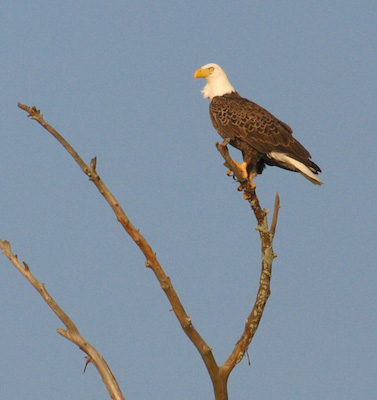

In [ ]:
import torch

# Get an image from the validation dataset
image, label = val_ds[10]['image'], val_ds[10]['label']
image



In [ ]:
# Preprocess the image
image = val_transforms(image.convert("RGB")).unsqueeze(0)

# Move image to the same device as the model
image = image.to(model.device)

# Make prediction
with torch.no_grad():
    logits = model(image).logits

# Get predicted label
predicted_label = logits.argmax(-1).item()

# Convert label id to label name
predicted_label_name = id2label[predicted_label]

print(f"Predicted label: {predicted_label_name}")

Predicted label: bald_eagle
